# K Nearest Neighbor
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using K-nearest Neighbor to classify the data points on the target ("Outcome" of the stop and search).

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

from imblearn.over_sampling import SMOTE

In [2]:
police_actions_simple = ["0", "1", "2", "3", "4", "5", "6", "7"]

def evaluate(model, X_train, y_train, X_test, y_test, target_classes=police_actions_simple, average='weighted', binary=False, rotation=0, fontsize=24):
    print(f"Accurancy Score (Train): {int(np.around(model.score(X_train, y_train), 2) * 100)}%")
    print(f"Accuracy Score (Test): {int(np.around(model.score(X_test, y_test), 2) * 100)}%")
    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    print(f"\nPrecision Score (Train): {int(np.around(precision_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Precision Score (Test): {int(np.around(precision_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nRecall Score (Train): {int(np.around(recall_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Recall Score (Test): {int(np.around(recall_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nF1 Score (Train): {int(np.around(f1_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"F1 Score (Test): {int(np.around(f1_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nMCC (Train): {matthews_corrcoef(y_train, y_train_predictions)}")
    print(f"MCC (Test): {matthews_corrcoef(y_test, y_test_predictions)}")
    print("\n Confusion Matrix")
    if binary:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=["No Action", "Action"], rotation=rotation, fontsize=fontsize)
    else:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=target_classes, rotation=rotation, fontsize=fontsize)

## Cleaning the Data set

In [3]:
data = pd.read_csv("data.csv")

# data = data.dropna()
data = util.data_cleaner(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values


In [4]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split data into train and test

In [5]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [6]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

Accurancy Score (Train): 70%
Accuracy Score (Test): 62%

Precision Score (Train): 67%
Precision Score (Test): 51%

Recall Score (Train): 70%
Recall Score (Test): 62%

F1 Score (Train): 64%
F1 Score (Test): 54%

MCC (Train): 0.30600115852076637
MCC (Test): 0.05990624491820985

 Confusion Matrix


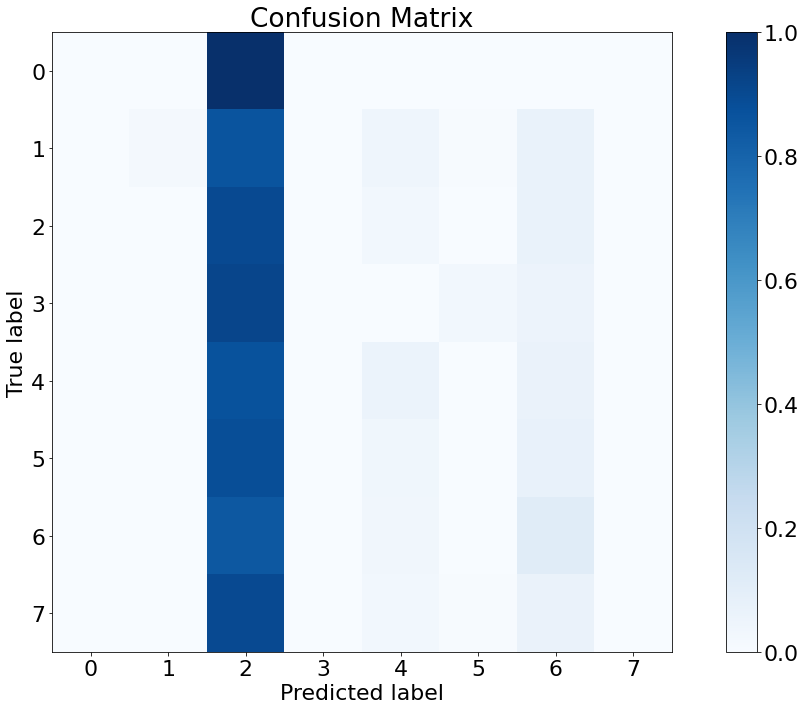

In [7]:
evaluate(model=knn, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

## Split target into "Police Action" (1) and "No Action" (0)

I will try to repeat the above process, but instead of the target being split into eight classes, I split it into two: either there was police action after the stop and search, or there wasn't.

In [8]:
#Replace all values in Outcome column, with 0 if "Nothing found - no further action", else 1.
# Reference for dictionary idea to replace values: https://stackoverflow.com/questions/17114904/python-pandas-replacing-strings-in-dataframe-with-numbers
outcome_splitter = {
    "Nothing found - no further action": 0, 
    "Article found - Detailed outcome unavailable": 1, 
    "Local resolution": 1,
    "Offender cautioned": 1,
    "Offender given drugs possession warning": 1,
    "Offender given penalty notice": 1,
    "Suspect arrested": 1,
    "Suspect summonsed to court": 1
    }
data_binary = data.applymap(lambda s: outcome_splitter.get(s) if s in outcome_splitter else s)
data_binary.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,Person search,2015-03-02 16:40:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
1,Person search,2015-03-02 16:40:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
2,Person search,2015-03-02 18:45:00+00:00,51.512286,-0.114491,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
4,Person and Vehicle search,2015-03-03 15:50:00+00:00,51.512286,-0.114491,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
5,Person search,2015-03-03 20:20:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,0


In [9]:
data_binary_encoded, encoders_binary = util.data_encoder(data_binary)

print(encoders_binary)
data_binary_encoded.head()

{'Type Encoder': LabelEncoder(), 'Gender Encoder': LabelEncoder(), 'Age range Encoder': LabelEncoder(), 'Officer-defined ethnicity Encoder': LabelEncoder(), 'Legislation Encoder': LabelEncoder(), 'Object of search Encoder': LabelEncoder(), 'Outcome Encoder': LabelEncoder(), 'Date Encoder': LabelEncoder()}


,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,1
1,1,0,51.512286,-0.114491,1,1,0,4,8,1
2,1,1,51.512286,-0.114491,1,1,4,4,8,1
4,0,2,51.512286,-0.114491,1,1,4,4,8,1
5,1,3,51.512286,-0.114491,1,1,0,3,3,0


In [10]:
# Split into features and target
target_binary = data_binary_encoded["Outcome"]
features_binary = data_binary_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(features_binary, target_binary, test_size=0.2, random_state=10)

In [11]:
knn_binary = KNeighborsClassifier()
knn_binary.fit(X_train_binary, y_train_binary) 

y_predictions_binary = knn_binary.predict(X_test_binary)


Accurancy Score (Train): 74%
Accuracy Score (Test): 61%

Precision Score (Train): 73%
Precision Score (Test): 57%

Recall Score (Train): 74%
Recall Score (Test): 61%

F1 Score (Train): 73%
F1 Score (Test): 59%

MCC (Train): 0.39578454481847486
MCC (Test): 0.06892267717382349

 Confusion Matrix


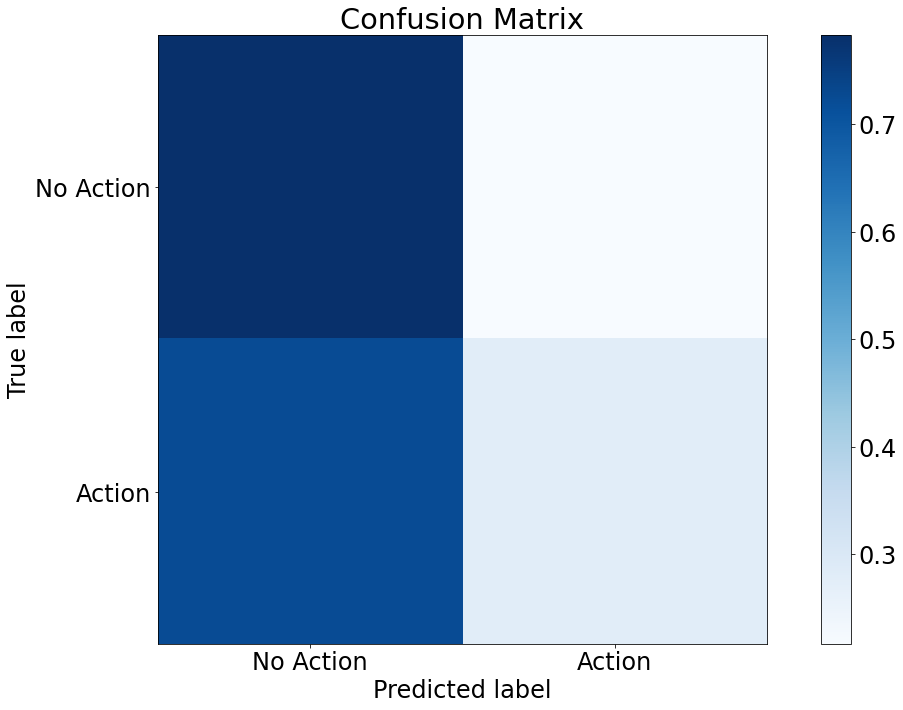

In [12]:
evaluate(model=knn_binary, X_train=X_train_binary, y_train=y_train_binary, X_test=X_test_binary, y_test=y_test_binary, binary=True)

Still, the model is heavily biased towards predicting no-action after a stop and search.

Let's compare the ratio of no-action to action in our y_train and y_test... perhaps our training data doesn't capture this ratio well

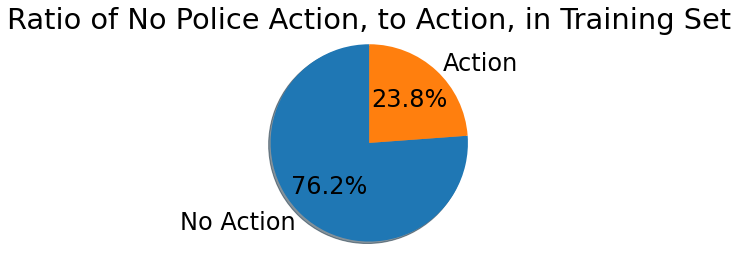

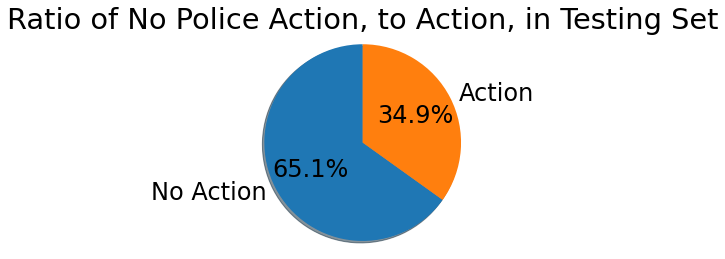

In [13]:
#Reference for Pie Chart: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
_, frequencies_predict = np.unique(y_predictions_binary, return_counts=True)
_, frequencies_test = np.unique(y_test_binary, return_counts=True)

labels = ["No Action", "Action"]

fig1, ax1 = plt.subplots()
ax1.pie(frequencies_predict, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of No Police Action, to Action, in Training Set")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(frequencies_test, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of No Police Action, to Action, in Testing Set")
plt.show()

As seen above, there is a signfiicant mismatch between the number of 0s and 1s when comparing the test set vs the training set. Perhaps K Cross Validation will be better for train/test splitting.

## Training Using K-Fold Cross Validation

In [14]:

#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_binary_k, X_test_binary_k, y_train_binary_k, y_test_binary_k = train_test_split(features_binary, target_binary, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [X_train_binary_k, y_train_binary_k]
k_fold_binary_data = pd.concat(frames, axis=1)

#K-cross validation on k_fold_binary_data 
knn_kfold = KNeighborsClassifier()
util.k_fold_train(model=knn_kfold, data=k_fold_binary_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7398883187443405
Accuracy (Test): 0.7398883187443405
Precision (Train): 0.7312744940074982
Precision (Test): 0.7312744940074982
MCC (Train): 0.39415728340426
MCC (Test): 0.39415728340426

Fold #2, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7397457826072374
Accuracy (Test): 0.7397457826072374
Precision (Train): 0.7309343538774067
Precision (Test): 0.7309343538774067
MCC (Train): 0.391687657025871
MCC (Test): 0.391687657025871

Fold #3, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7399721635308717
Accuracy (Test): 0.7399721635308717
Precision (Train): 0.7314179856338202
Precision (Test): 0.7314179856338202
MCC (Train): 0.39432307216009005
MCC (Test): 0.39432307216009005

Fold #4, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7381359627058389
Accuracy (Test): 0.7381359627058389
Precision (Train): 

As you can see, performance is better when splitting using k-fold. Also significantly less difference between training and testing scores, implying less overfitting.

Let's plot a confusion matrix, using the testing data set above. Notice, this is data that has not been used to train the model using K cross valdiation.

Accurancy Score (Train): 71%
Accuracy Score (Test): 60%

Precision Score (Train): 70%
Precision Score (Test): 56%

Recall Score (Train): 71%
Recall Score (Test): 60%

F1 Score (Train): 70%
F1 Score (Test): 57%

MCC (Train): 0.3260515367561941
MCC (Test): 0.058070391345087555

 Confusion Matrix


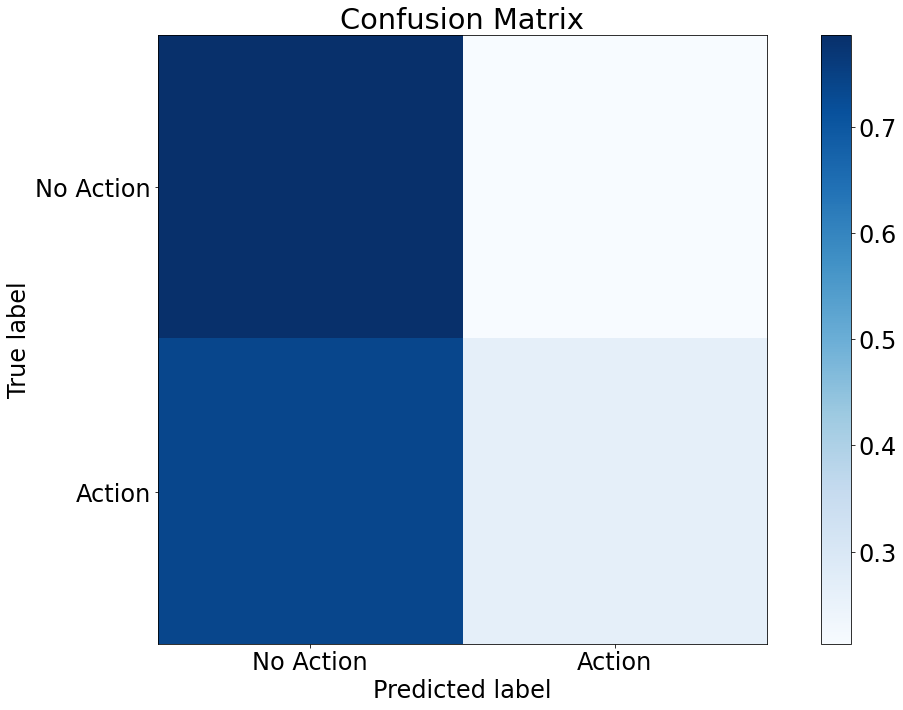

In [15]:
evaluate(model=knn_kfold, X_train=X_train_binary_k, y_train=y_train_binary_k, X_test=X_test_binary_k, y_test=y_test_binary_k, binary=True)

Less false negatives, although still signficant bias to predicting no police action after stop and search.

## K-fold with all target classes

We repeat the above process, but using all target categories for the sake of completion.

In [16]:
#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(features, target, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames_2 = [X_train_k, y_train_k]
k_fold_data = pd.concat(frames_2, axis=1)

#K-cross validation on k_fold_binary_data 
knn_kfold_all_classes = KNeighborsClassifier()
util.k_fold_train(model=knn_kfold_all_classes, data=k_fold_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6972364758359325
Accuracy (Test): 0.6972364758359325
Precision (Train): 0.6678841545209896
Precision (Test): 0.6678841545209896
MCC (Train): 0.302276347083101
MCC (Test): 0.302276347083101

Fold #2, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6980078478720193
Accuracy (Test): 0.6980078478720193
Precision (Train): 0.6709236029382277
Precision (Test): 0.6709236029382277
MCC (Train): 0.30096616470934645
MCC (Test): 0.30096616470934645

Fold #3, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6969681725190328
Accuracy (Test): 0.6969681725190328
Precision (Train): 0.6698156043098459
Precision (Test): 0.6698156043098459
MCC (Train): 0.30211240002364065
MCC (Test): 0.30211240002364065

Fold #4, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6967417915953986
Accuracy (Test): 0.6967417915953986
Precision (Tr

Accurancy Score (Train): 68%
Accuracy Score (Test): 62%

Precision Score (Train): 64%
Precision Score (Test): 51%

Recall Score (Train): 68%
Recall Score (Test): 62%

F1 Score (Train): 62%
F1 Score (Test): 54%

MCC (Train): 0.25375762279010033
MCC (Test): 0.05598398458275047

 Confusion Matrix


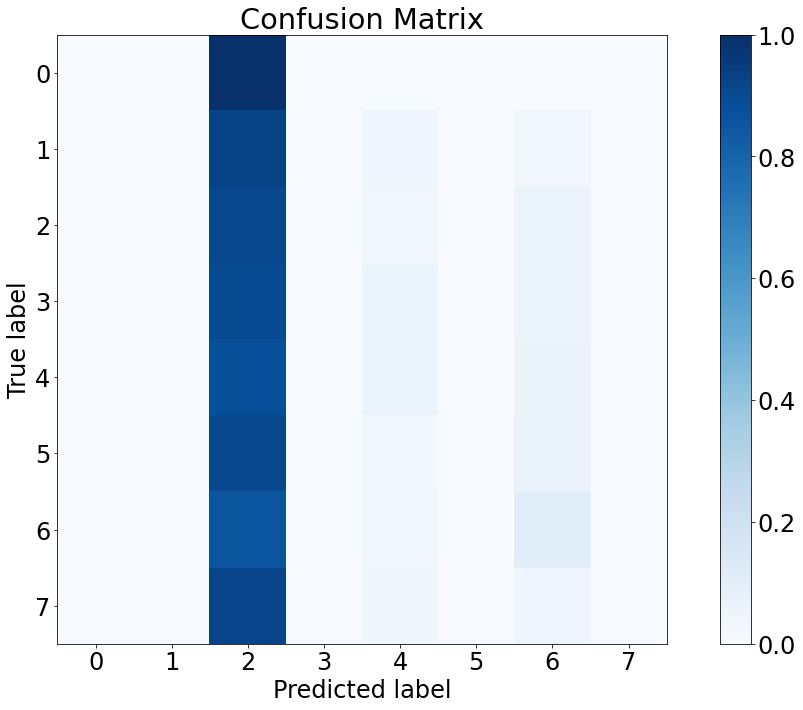

In [17]:
evaluate(model=knn_kfold_all_classes, X_train=X_train_k, y_train=y_train_k, X_test=X_test_k, y_test=y_test_k)

The model pefroms better than without k-fold cross validation, however is once again, still clearly biased towards predicting no police action following from a search.

# Using SMOTE

We use SMOTE to even out the unbalanced dataset

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


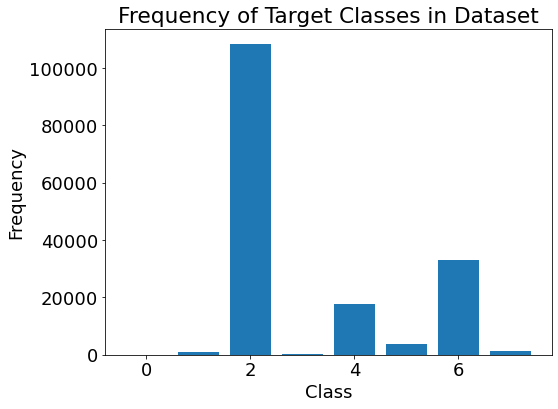

In [20]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"], figsize=(8,6), fontsize=18)

Class 0: 0.02%     (32)
Class 1: 0.67%     (891)
Class 2: 65.49%     (86784)
Class 3: 0.1%     (131)
Class 4: 10.74%     (14229)
Class 5: 2.27%     (3014)
Class 6: 19.95%     (26436)
Class 7: 0.76%     (1003)
Total: 132520


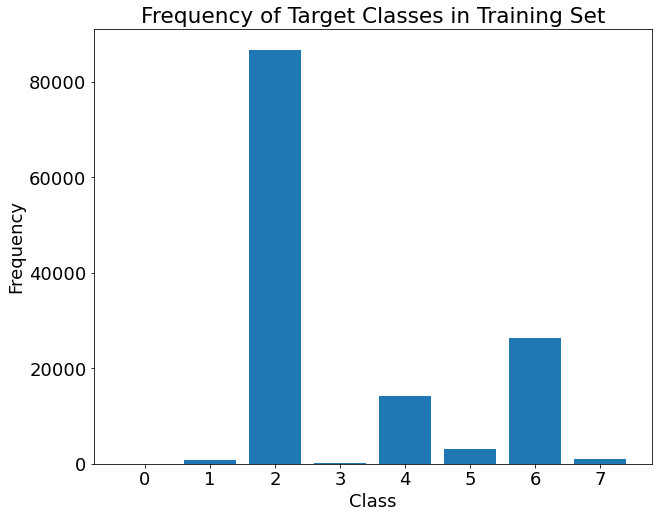

In [21]:
#Train/test split data_encoded
usm.display_frequencies(y_train, title="Frequency of Target Classes in Training Set")

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


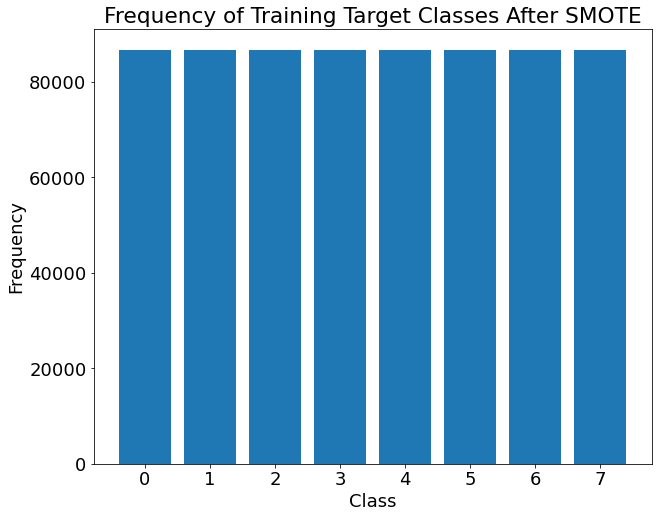

In [22]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
usm.display_frequencies(y_smote, title="Frequency of Training Target Classes After SMOTE")

In [23]:
knn_smote = KNeighborsClassifier()
knn_smote.fit(X_smote, y_smote)

KNeighborsClassifier()

Accurancy Score (Train): 56%
Accuracy Score (Test): 24%

Precision Score (Train): 81%
Precision Score (Test): 55%

Recall Score (Train): 56%
Recall Score (Test): 24%

F1 Score (Train): 63%
F1 Score (Test): 32%

MCC (Train): 0.42530344618264865
MCC (Test): 0.062280159906245185

 Confusion Matrix


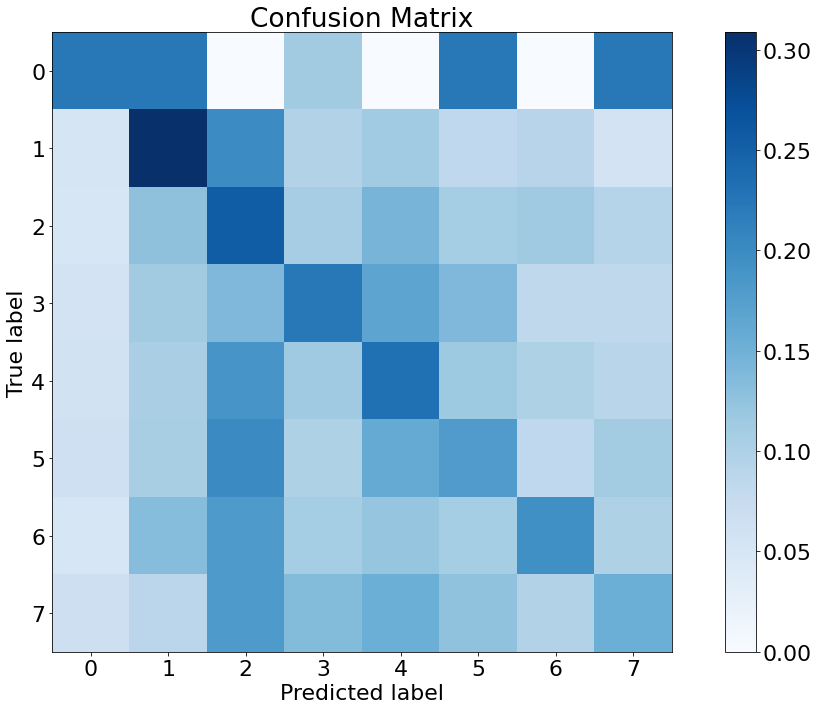

In [24]:
evaluate(model=knn_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

# Using Biased SMOTE (to majority class)
We over sample minority classes, but not to an extent that equalizes them to the majority class


Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


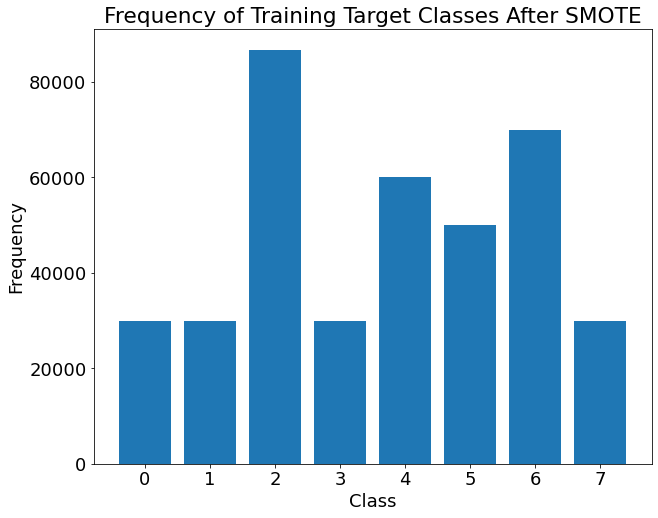

In [25]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote2, y_smote2 = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote2, title="Frequency of Training Target Classes After SMOTE")

In [26]:
knn_smote_biased = KNeighborsClassifier()
knn_smote_biased.fit(X_smote2, y_smote2)

KNeighborsClassifier()

Accurancy Score (Train): 63%
Accuracy Score (Test): 34%

Precision Score (Train): 78%
Precision Score (Test): 53%

Recall Score (Train): 63%
Recall Score (Test): 34%

F1 Score (Train): 68%
F1 Score (Test): 41%

MCC (Train): 0.4524575186001574
MCC (Test): 0.06898577829822573

 Confusion Matrix


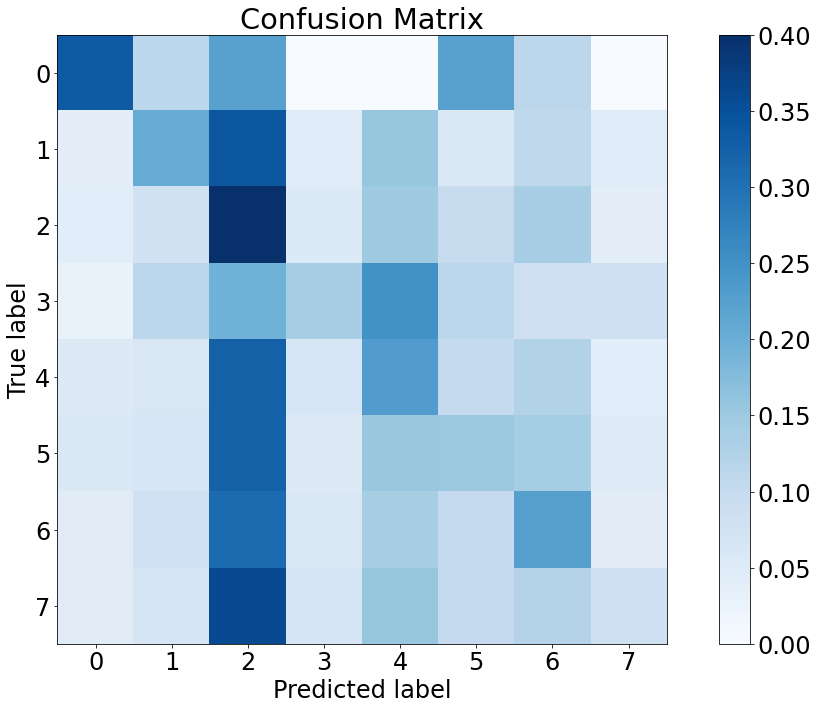

In [27]:
evaluate(model=knn_smote_biased, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Using Biased SMOTE (to minority class)


Class 0: 13.95%     (160000)
Class 1: 13.95%     (160000)
Class 2: 7.57%     (86784)
Class 3: 13.95%     (160000)
Class 4: 12.21%     (140000)
Class 5: 13.08%     (150000)
Class 6: 11.34%     (130000)
Class 7: 13.95%     (160000)
Total: 1146784


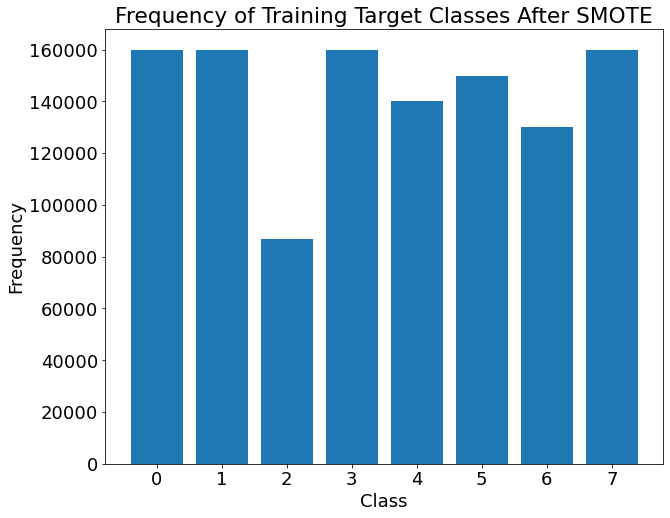

In [28]:
sampling_strategy = {0:160000, 1:160000, 2:86784, 3:160000, 4:140000, 5:150000, 6:130000, 7:160000}
X_smote3, y_smote3 = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote3, title="Frequency of Training Target Classes After SMOTE")

In [29]:
knn_smote_biased_min = KNeighborsClassifier()
knn_smote_biased_min.fit(X_smote3, y_smote3)

KNeighborsClassifier()

Accurancy Score (Train): 52%
Accuracy Score (Test): 19%

Precision Score (Train): 83%
Precision Score (Test): 56%

Recall Score (Train): 52%
Recall Score (Test): 19%

F1 Score (Train): 57%
F1 Score (Test): 26%

MCC (Train): 0.42903139057283723
MCC (Test): 0.0637817123392406

 Confusion Matrix


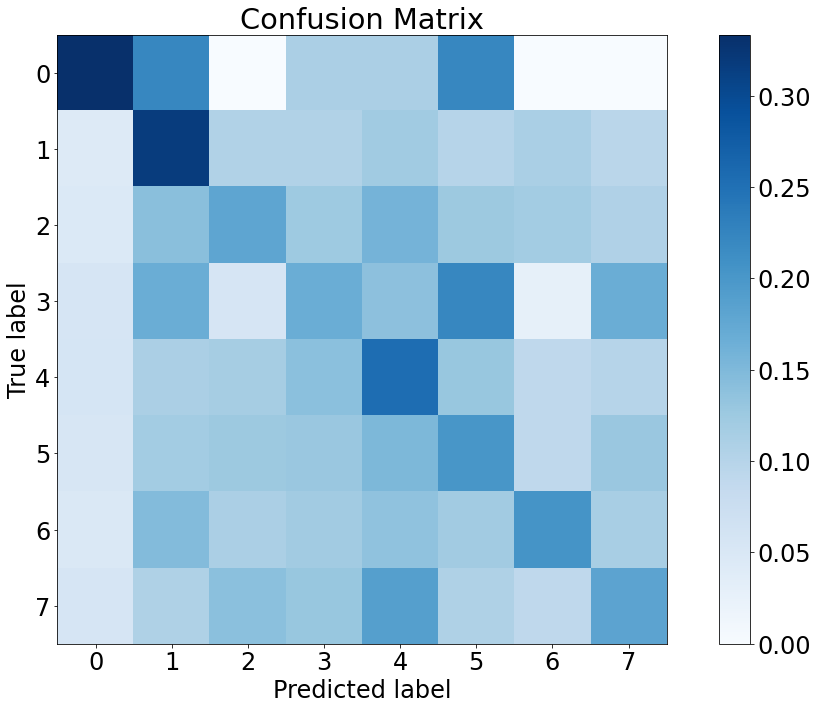

In [30]:
evaluate(model=knn_smote_biased_min, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## Undersampling



Class 0: 0.04%     (32)
Class 1: 1.0%     (891)
Class 2: 48.69%     (43392)
Class 3: 0.15%     (131)
Class 4: 15.96%     (14229)
Class 5: 3.38%     (3014)
Class 6: 29.66%     (26436)
Class 7: 1.13%     (1003)
Total: 89128


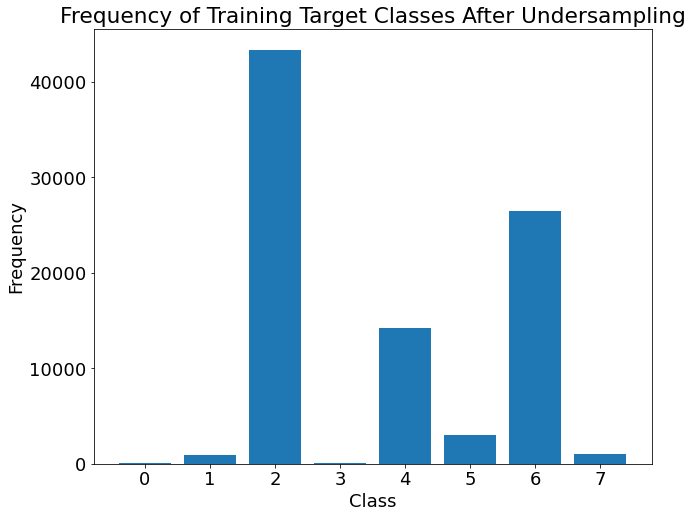

In [31]:
X_under, y_under= usm.under_sample(X_train, y_train, majority_multiplier=0.5)
usm.display_frequencies(y_under, title="Frequency of Training Target Classes After Undersampling")

In [32]:
knn_smote_under_sample = KNeighborsClassifier()
knn_smote_under_sample.fit(X_under, y_under)

KNeighborsClassifier()

Accurancy Score (Train): 65%
Accuracy Score (Test): 54%

Precision Score (Train): 63%
Precision Score (Test): 51%

Recall Score (Train): 65%
Recall Score (Test): 54%

F1 Score (Train): 63%
F1 Score (Test): 52%

MCC (Train): 0.2813020145962403
MCC (Test): 0.05896366037205539

 Confusion Matrix


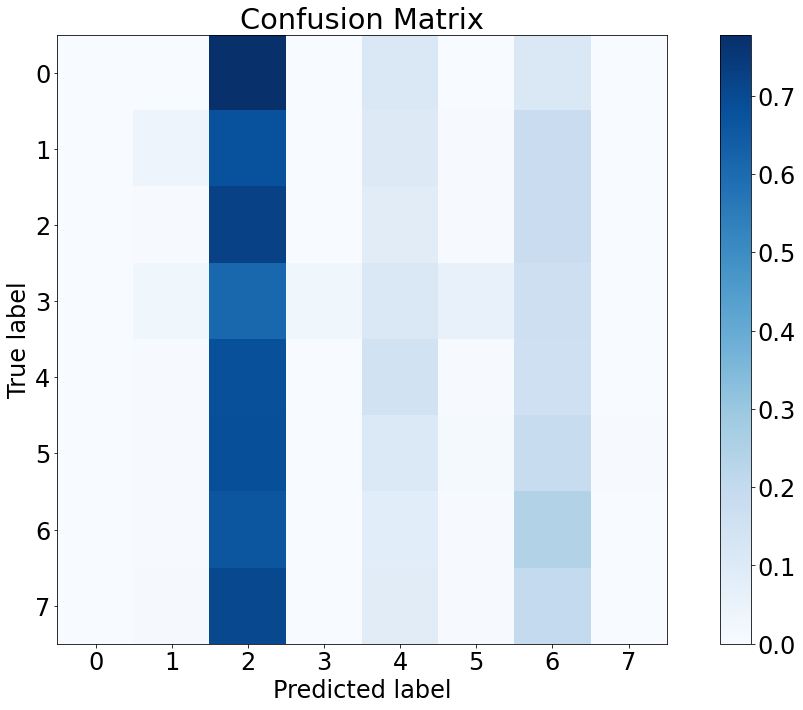

In [33]:
evaluate(model=knn_smote_under_sample, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## Undersample + SMOTE

Class 0: 12.5%     (78105)
Class 1: 12.5%     (78105)
Class 2: 12.5%     (78105)
Class 3: 12.5%     (78105)
Class 4: 12.5%     (78105)
Class 5: 12.5%     (78105)
Class 6: 12.5%     (78105)
Class 7: 12.5%     (78105)
Total: 624840


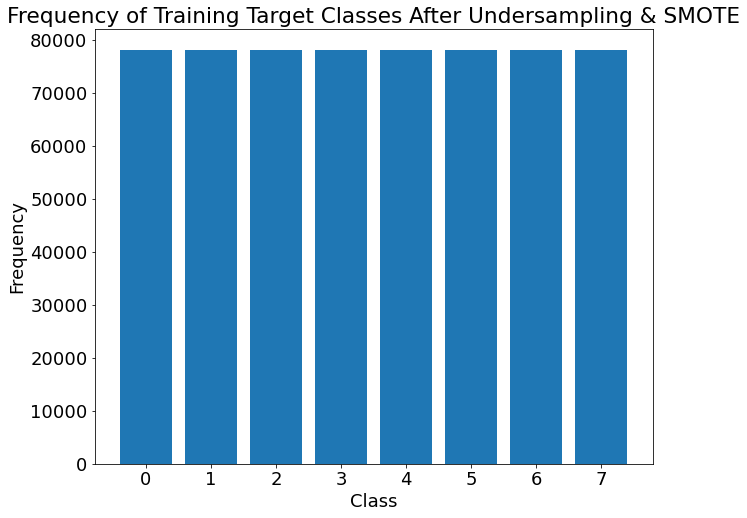

In [34]:
X_under2, y_under2= usm.under_sample(X_train, y_train, majority_multiplier=0.9)
X_smote4, y_smote4 = usm.smote_data(X_under2, y_under2)
usm.display_frequencies(y_smote4, title="Frequency of Training Target Classes After Undersampling & SMOTE")

In [35]:
knn_smote_under_and_smote = KNeighborsClassifier()
knn_smote_under_and_smote.fit(X_smote4, y_smote4)

KNeighborsClassifier()

Accurancy Score (Train): 53%
Accuracy Score (Test): 23%

Precision Score (Train): 79%
Precision Score (Test): 55%

Recall Score (Train): 53%
Recall Score (Test): 23%

F1 Score (Train): 60%
F1 Score (Test): 31%

MCC (Train): 0.39880035353908405
MCC (Test): 0.05979600583861864

 Confusion Matrix


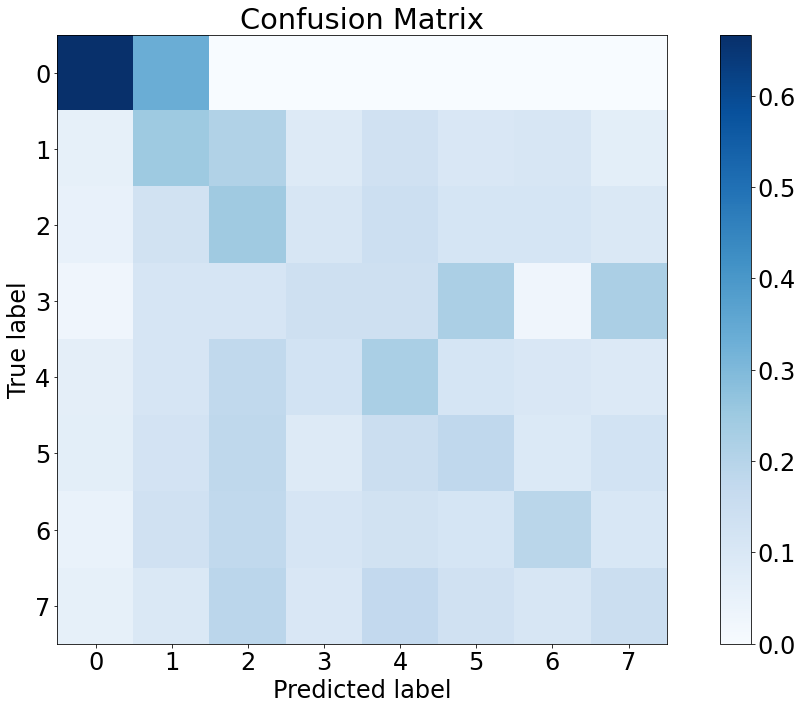

In [36]:
evaluate(model=knn_smote_under_and_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Best precision test scores using SMOTE, with frequencies for all classes regularized

## Scaling Data

In [37]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_scaled = pd.DataFrame(features_scaled, columns=data.drop("Outcome", axis=1).columns)

X_scaled.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search
0,0.641784,-1.720167,0.031037,0.055872,0.265176,0.379816,-1.346153,1.233580,7.911489
1,0.641784,-1.720167,0.031037,0.055872,0.265176,0.379816,-1.346153,1.233580,7.911489
2,0.641784,-1.720133,0.031037,0.055872,0.265176,0.379816,1.062035,1.233580,7.911489
3,-1.526923,-1.720099,0.031037,0.055872,0.265176,0.379816,1.062035,1.233580,7.911489
4,0.641784,-1.720065,0.031037,0.055872,0.265176,0.379816,-1.346153,-0.453747,0.417036


In [38]:
#Split Scaled Data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, target, test_size=0.2, random_state=10)

In [39]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train_scaled)

KNeighborsClassifier()

Accurancy Score (Train): 70%
Accuracy Score (Test): 61%

Precision Score (Train): 68%
Precision Score (Test): 53%

Recall Score (Train): 70%
Recall Score (Test): 61%

F1 Score (Train): 65%
F1 Score (Test): 55%

MCC (Train): 0.31839115530690937
MCC (Test): 0.07142384898213346

 Confusion Matrix


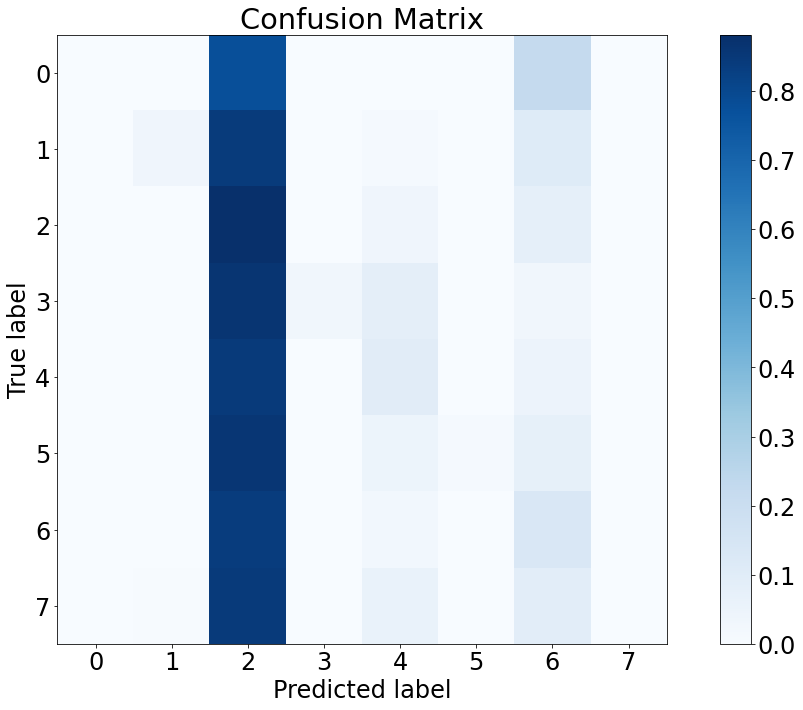

In [40]:
evaluate(model=knn_scaled, X_train=X_train_scaled, y_train=y_train_scaled, X_test=X_test_scaled, y_test=y_test_scaled)

## Scaling Data + SMOTE

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


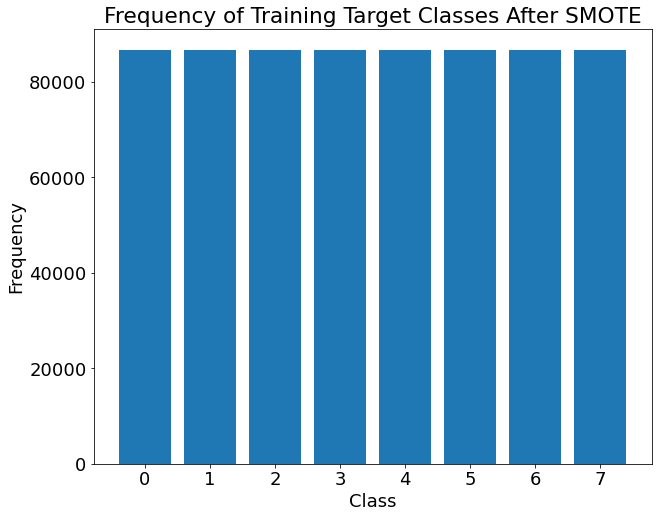

In [41]:
X_smote5, y_smote5 = usm.smote_data(X_train_scaled, y_train_scaled)
usm.display_frequencies(y_smote5, title="Frequency of Training Target Classes After SMOTE")

In [42]:
knn_scaled_smote = KNeighborsClassifier()
knn_scaled_smote.fit(X_smote5, y_smote5)

KNeighborsClassifier()

Accurancy Score (Train): 60%
Accuracy Score (Test): 33%

Precision Score (Train): 77%
Precision Score (Test): 54%

Recall Score (Train): 60%
Recall Score (Test): 33%

F1 Score (Train): 64%
F1 Score (Test): 40%

MCC (Train): 0.44140363209097067
MCC (Test): 0.0837118002886179

 Confusion Matrix


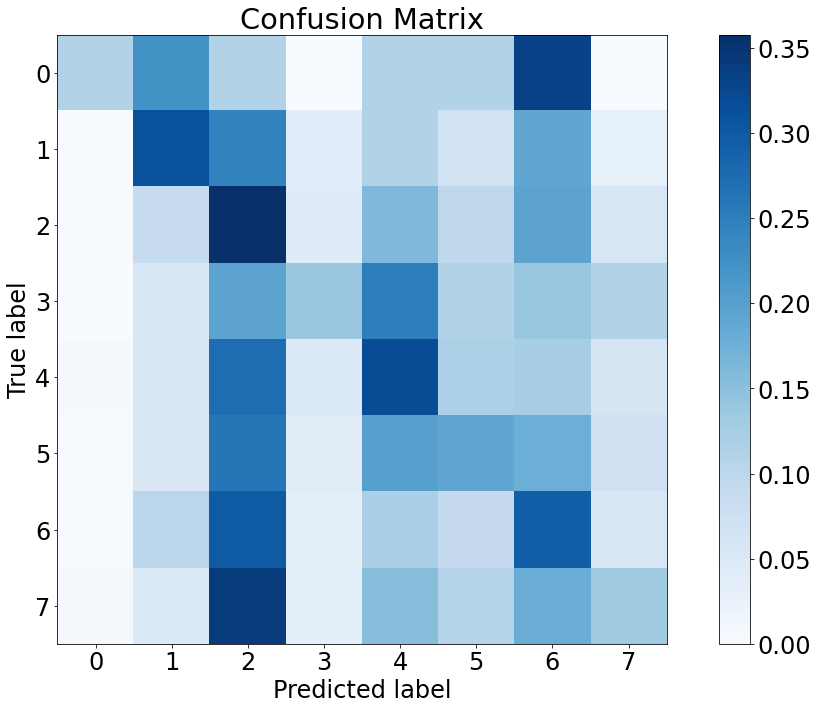

In [43]:
evaluate(model=knn_scaled_smote, X_train=X_train_scaled, y_train=y_train_scaled, X_test=X_test_scaled, y_test=y_test_scaled)

## Using Grid Search to Tune the K Hyperparameter

In [53]:
from sklearn.metrics import make_scorer

#From https://scikit-learn.org/stable/modules/model_evaluation.html#scoring 
scorer = make_scorer(matthews_corrcoef)

search = {
    "n_neighbors":[1], #also tested values from 1 to 30
    "weights": ["distance"], #also tested "uniform"
    "metric": ["minkowski"] #also tested "euclidean", "chebyshev", "wminkowski", "seuclidean", "mahalanobis", "manhattan"
    #also test "algorithm": ["auto", "ball_tree", "kd_tree"]
}

knn_grid_search = GridSearchCV(KNeighborsClassifier(), search, verbose=100, cv=10, n_jobs=-1, scoring=scorer)


In [54]:
%%time

knn_grid_search.fit(X_smote, y_smote)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   14.1s remaining:   56.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   14.5s remaining:   33.9s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   14.7s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   14.7s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   14.7s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   14.7s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   14.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished
CPU times: user 3.02 s, sys: 297 ms, total: 3.32 s
Wall time: 18.3 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski'], 'n_neighbors': [1],
                         'weights': ['distance']},
             scoring=make_scorer(matthews_corrcoef), verbose=100)

Accurancy Score (Train): 97%
Accuracy Score (Test): 33%

Precision Score (Train): 98%
Precision Score (Test): 56%

Recall Score (Train): 97%
Recall Score (Test): 33%

F1 Score (Train): 98%
F1 Score (Test): 41%

MCC (Train): 0.9525990689103672
MCC (Test): 0.10170839448140115

 Confusion Matrix


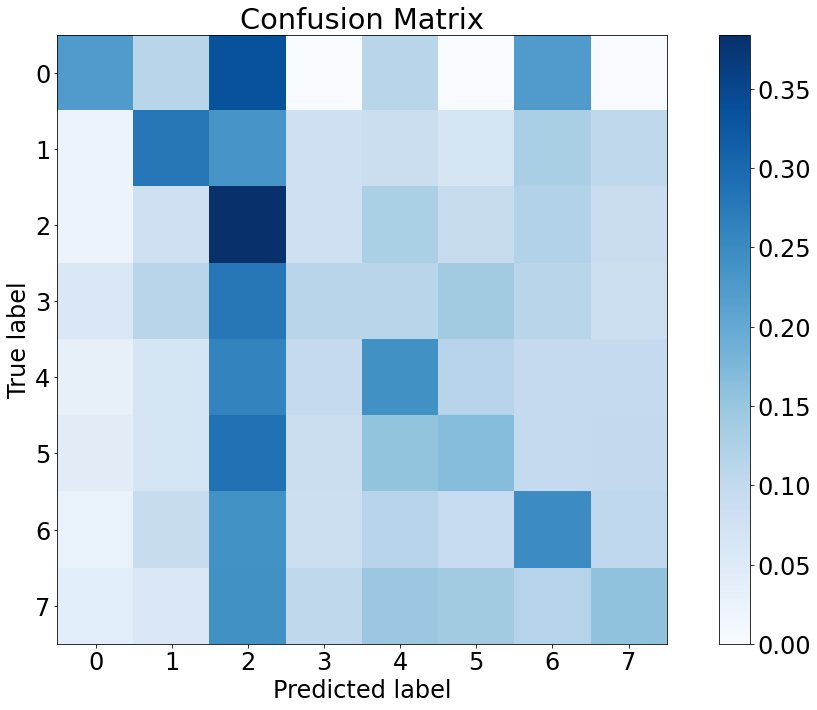

CPU times: user 2.74 s, sys: 35.4 ms, total: 2.77 s
Wall time: 2.77 s


In [55]:
%%time
evaluate(model=knn_grid_search.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [47]:
knn_grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}

The best model is a weighted k nearest neighbors (weights=distance) where the "K" hyper parameter is equal to 1 (n_neighbors=1). Finally, the two best distance measuring metrics were minkowski and manhattan. The former yieleded a better matrix, but less precision on the testing set.

## Visualizing Relationship between Model Performance and value of K

In [79]:
k_values = list(range(30, 150))
mcc_test_vals = []
mcc_train_vals = []
precision_test_vals = []
precision_train_vals = []

for k in k_values:
    print(f"Starting k={k}")
    knn_test = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn_test.fit(X_smote, y_smote)
    print(f"Fitting complete, evaluating...")
    y_test_predictions = knn_test.predict(X_test)
    y_train_predictions = knn_test.predict(X_train)

    mcc_test = matthews_corrcoef(y_test, y_test_predictions)
    mcc_train = matthews_corrcoef(y_train, y_train_predictions)

    precision_test = precision_score(y_test, y_test_predictions, average="micro")
    precision_train = precision_score(y_train, y_train_predictions, average="micro")

    mcc_test_vals.append(mcc_test)
    mcc_train_vals.append(mcc_train)
    precision_test_vals.append(precision_test)
    precision_train_vals.append(precision_train)


print(f"MCC Values:\n{mcc_test_vals}\n\n")
print(f"Precision Values:\n{precision_test_vals}")


Starting k=30
Fitting complete, evaluating...
Starting k=31
Fitting complete, evaluating...
Starting k=32
Fitting complete, evaluating...
Starting k=33
Fitting complete, evaluating...
Starting k=34
Fitting complete, evaluating...
Starting k=35
Fitting complete, evaluating...
Starting k=36
Fitting complete, evaluating...
Starting k=37
Fitting complete, evaluating...
Starting k=38
Fitting complete, evaluating...
Starting k=39
Fitting complete, evaluating...
Starting k=40
Fitting complete, evaluating...
Starting k=41
Fitting complete, evaluating...
Starting k=42
Fitting complete, evaluating...
Starting k=43
Fitting complete, evaluating...
Starting k=44
Fitting complete, evaluating...
Starting k=45
Fitting complete, evaluating...
Starting k=46
Fitting complete, evaluating...
Starting k=47
Fitting complete, evaluating...
Starting k=48
Fitting complete, evaluating...
Starting k=49
Fitting complete, evaluating...
Starting k=50
Fitting complete, evaluating...
Starting k=51
Fitting complete, ev

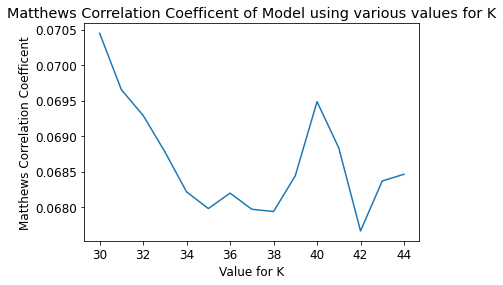

In [84]:
plt.rcParams.update({'font.size': 12})
plt.xlabel("Value for K")
plt.ylabel("Matthews Correlation Coefficent")
plt.title("Matthews Correlation Coefficent of Model using various values for K")
plt.plot(k_values[0:15], mcc_test_vals[0:15])
# plt.plot(k_values[25:35], mcc_train_vals[25:35])
plt.show()

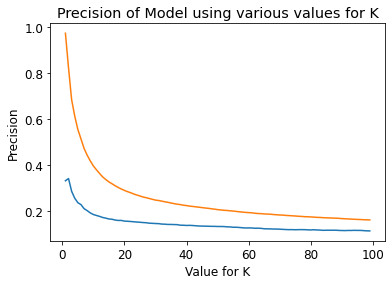

In [50]:
plt.xlabel("Value for K")
plt.ylabel("Precision")
plt.title("Precision of Model using various values for K")
plt.plot(k_values, precision_test_vals)
plt.plot(k_values, precision_train_vals)
plt.show()

When k=40 MCC reaches local maximum, so we check a model with n_neighbrs=40

In [85]:
knn_local_max = KNeighborsClassifier(n_neighbors=40)
knn_local_max.fit(X_smote, y_smote)

KNeighborsClassifier(n_neighbors=40)

Accurancy Score (Train): 23%
Accuracy Score (Test): 14%

Precision Score (Train): 65%
Precision Score (Test): 52%

Recall Score (Train): 23%
Recall Score (Test): 14%

F1 Score (Train): 27%
F1 Score (Test): 19%

MCC (Train): 0.1402129644975046
MCC (Test): 0.028642170815760558

 Confusion Matrix


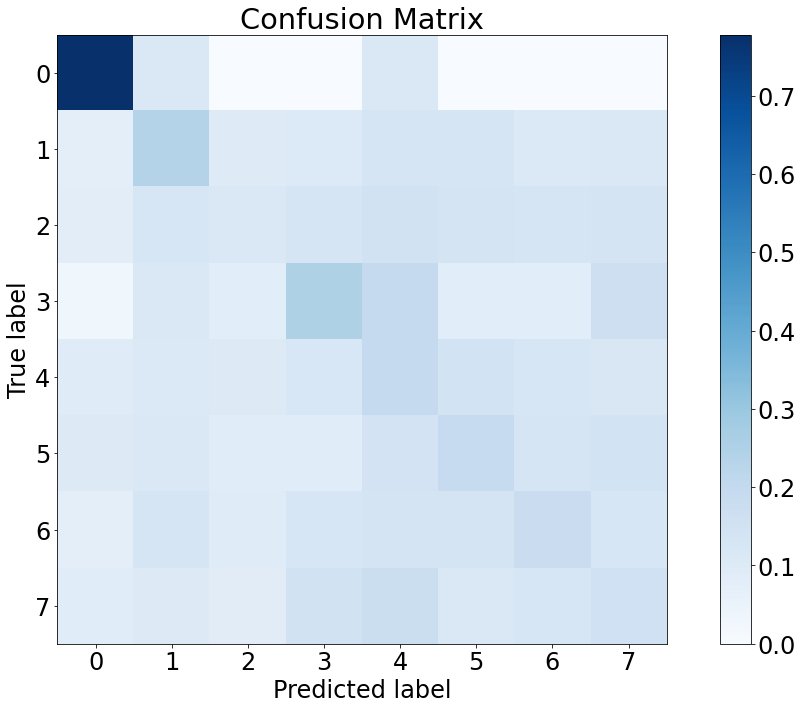

In [86]:
evaluate(model=knn_local_max, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)